In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

simplefilter(action='ignore', category=RuntimeWarning)
simplefilter(action='ignore', category=FutureWarning)

In [2]:
forcing_list = ['historical','hist-aer','hist-GHG','hist-nat']
name_list    = ['prec','scaling','scaling_thermo','scaling_dynamic']
model_path   = {'historical':'historical','hist-aer':'aer','hist-GHG':'GHG','hist-nat':'nat'}
var_name     = var_name
ax_locs      = {'historical':{'prec':0,'scaling_thermo':1,'scaling_dynamic':2},
                'hist-GHG':{'prec':3,'scaling_thermo':4,'scaling_dynamic':5},
                'hist-aer':{'prec':6,'scaling_thermo':7,'scaling_dynamic':8},
                'hist-nat':{'prec':9,'scaling_thermo':10,'scaling_dynamic':11},    
               }

In [3]:
def _scaling_rate(temp,var):
    var_ln = np.log(var)
    fit   = linregress(temp,var_ln)
    slp   = fit.slope
    sr    = (np.exp(slp)-1)*100
    return sr 

def scaling_rate_cal_global_warming(tas,var):  ### use global surface temperature
    tas = xr.DataArray(data=tas['gst'],dims=['time'],name='global_surface_temperature',coords=dict(time=tas.index))
    scaling_rate = xr.apply_ufunc(_scaling_rate,
                                  tas,
                                  var,
                                  vectorize=True,
                                  dask='parallelized', 
                                  input_core_dims=[['time'],['time']],
                                  output_dtypes=[float],
                                  )
    return scaling_rate

def scaling_rate_cal_local_warming(tas,var):  ### use local temperature conditioned on Rx1day occur
    scaling_rate = xr.apply_ufunc(_scaling_rate,
                                  tas,
                                  var,
                                  vectorize=True,
                                  dask='parallelized', 
                                  input_core_dims=[['time'],['time']],
                                  output_dtypes=[float],
                                  )
    return scaling_rate

def reshape(data):
    value1 = data.values
    value2 = np.concatenate((value1[:,:,[-1]],value1[:,:,:-1]),axis=2)
    value3 = np.concatenate((value1[:,:,1:],value1[:,:,[0]]),axis=2)
    value4 = np.concatenate((value1[:,[0],:],value1[:,:-1,:]),axis=1)
    value5 = np.concatenate((value1[:,1:,:],value1[:,[-1],:]),axis=1)
    value6 = np.concatenate((value3[:,[0],:],value3[:,:-1,:]),axis=1)
    value7 = np.concatenate((value3[:,1:,:],value3[:,[-1],:]),axis=1)
    value8 = np.concatenate((value2[:,[0],:],value2[:,:-1,:]),axis=1)
    value9 = np.concatenate((value2[:,1:,:],value2[:,[-1],:]),axis=1)
    value = (value1 + value2 + value3 + value4 + value5 + value6 + value7 + value8 + value9) / 9
    data.values = value
    return data


## calculate changes in Rx1day and its terms with respect to global warming

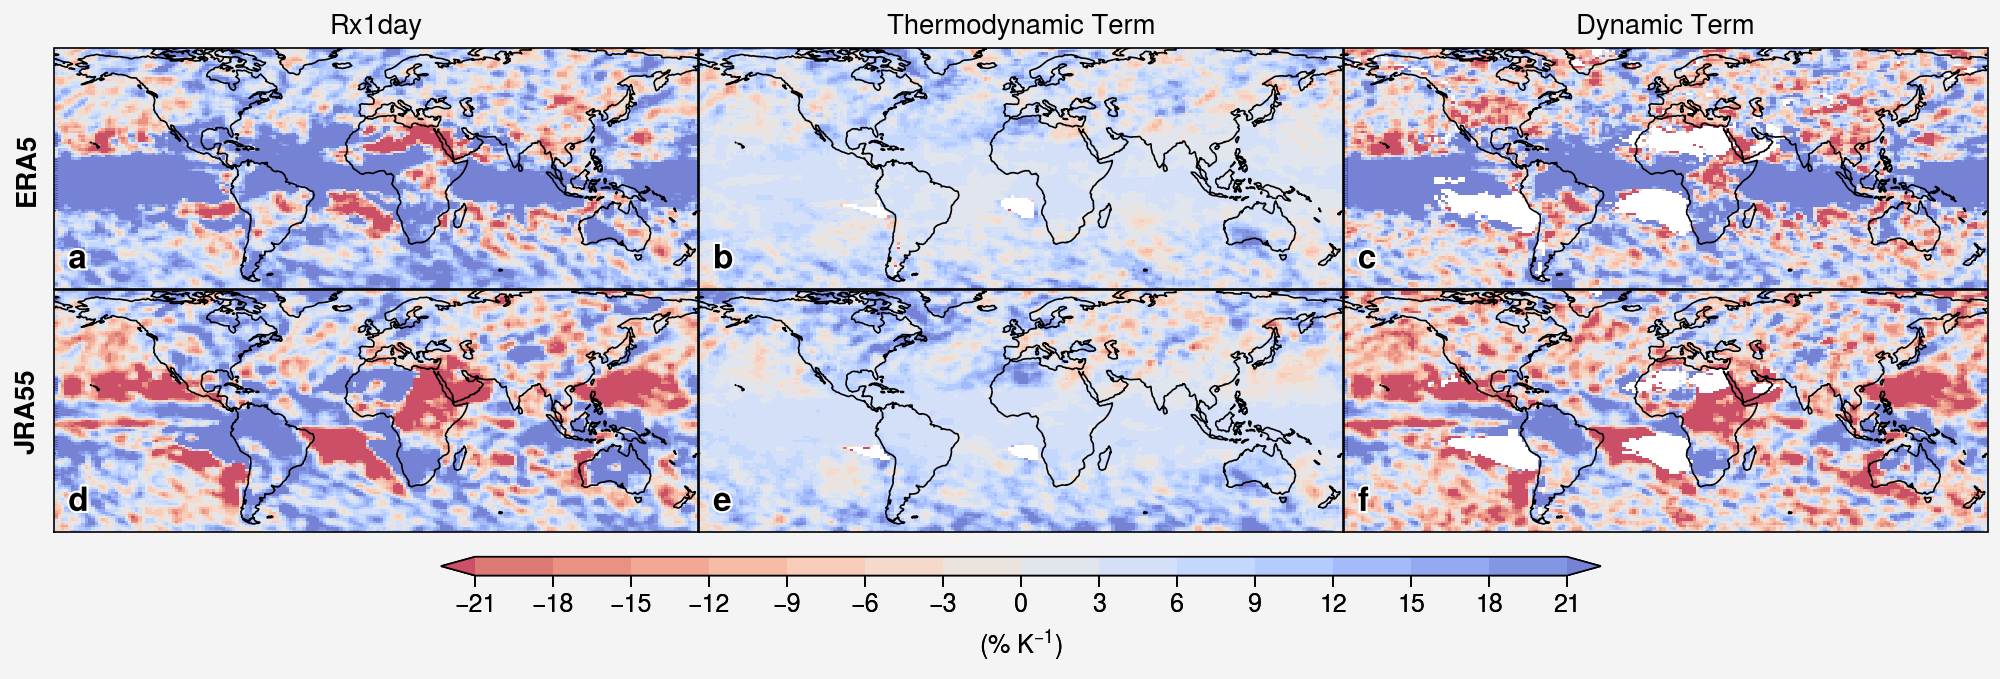

In [8]:
fig, axs = pplot.subplots(ncols=3,nrows=2,span=False,wspace=(0.05,0.05),hspace=(0.05),proj='pcarree',width=10)
axs.format(
    grid=False,
    leftlabels=('ERA5','JRA55'),
)

forcing_list = ['ERA5','JRA55']

ax_locs      = {
                'ERA5':{'prec':0,'scaling_thermo':1,'scaling_dynamic':2},
                'JRA55':{'prec':3,'scaling_thermo':4,'scaling_dynamic':5}
               }
# cmap=cmaps.BlueDarkRed18_r
cmap=cmaps.MPL_coolwarm_r
levels = MaxNLocator(nbins=15).tick_values(-21, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

era5_gst = pd.read_csv('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_res/era5/era5_global_mean_surf_temp.csv',header=0,index_col=0)
jra55_gst = pd.read_csv('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_res/jra55/jra55_global_mean_surf_temp.csv',header=0,index_col=0)

for f in forcing_list:
    forcing  = f
    if forcing == 'ERA5':
        src_id = 'era5'
        run = 'reanalysis'
        file_prec = glob.glob(forcing_dir['era5'] + 'prec' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        era5_prec = xr.open_dataarray(file_prec)
        era5_prec = era5_prec.sel(time=slice('1960','2014'))
        era5_prec['time'] = range(1960,2015)
        era5_prec = era5_prec.rename({'longitude':'lon','latitude':'lat'})
        era5_prec = era5_prec.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        era5_prec[:,:,-1] = (era5_prec[:,:,-2] + era5_prec[:,:,0]) / 2
        era5_prec = reshape(era5_prec)
        era5_tas  = xr.open_dataarray('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_res_NW/era5/era5_gst_1960-2014.nc')
        era5_tas = era5_tas.sel(time=slice('1960','2014'))
        era5_tas['time'] = range(1960,2015)
        era5_tas = era5_tas.rename({'longitude':'lon','latitude':'lat'})
        era5_tas = era5_tas.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        era5_tas[:,:,-1] = (era5_tas[:,:,-2] + era5_tas[:,:,0]) / 2
        era5_tas = reshape(era5_tas)
        era5_prec_rate = scaling_rate_cal_global_warming(tas = era5_gst.loc[1960:2014], var = era5_prec)

        file_scaling = glob.glob(forcing_dir['era5'] + 'scaling' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        era5_scaling = xr.open_dataarray(file_scaling)
        era5_scaling = era5_scaling.sel(time=slice('1960','2014'))
        era5_scaling['time'] = range(1960,2015)
        era5_scaling = era5_scaling.rename({'longitude':'lon','latitude':'lat'})
        era5_scaling = era5_scaling.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        era5_scaling[:,:,-1] = (era5_scaling[:,:,-2] + era5_scaling[:,:,0]) / 2
        era5_scaling = reshape(era5_scaling)

        file_scaling_thermo = glob.glob(forcing_dir['era5'] + 'scaling_thermo' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        era5_scaling_thermo = xr.open_dataarray(file_scaling_thermo)
        era5_scaling_thermo = era5_scaling_thermo.sel(time=slice('1960','2014'))
        era5_scaling_thermo['time'] = range(1960,2015)
        era5_scaling_thermo = era5_scaling_thermo.rename({'longitude':'lon','latitude':'lat'})
        era5_scaling_thermo = era5_scaling_thermo.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        era5_scaling_thermo[:,:,-1] = (era5_scaling_thermo[:,:,-2] + era5_scaling_thermo[:,:,0]) / 2
        era5_scaling_thermo = reshape(era5_scaling_thermo)
        era5_scaling_thermo = era5_scaling_thermo + era5_scaling.mean(axis=0)
        era5_scaling_thermo_rate = scaling_rate_cal_global_warming(tas = era5_gst.loc[1960:2014], var = era5_scaling_thermo)

        file_scaling_dynamic = glob.glob(forcing_dir['era5'] + 'scaling_dynamic' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        era5_scaling_dynamic = xr.open_dataarray(file_scaling_dynamic)
        era5_scaling_dynamic = era5_scaling_dynamic.sel(time=slice('1960','2014'))
        era5_scaling_dynamic['time'] = range(1960,2015)
        era5_scaling_dynamic = era5_scaling_dynamic.rename({'longitude':'lon','latitude':'lat'})
        era5_scaling_dynamic = era5_scaling_dynamic.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        era5_scaling_dynamic[:,:,-1] = (era5_scaling_dynamic[:,:,-2] + era5_scaling_dynamic[:,:,0]) / 2
        era5_scaling_dynamic = reshape(era5_scaling_dynamic)
        era5_scaling_dynamic = era5_scaling_dynamic + era5_scaling.mean(axis=0)
        era5_scaling_dynamic_rate = scaling_rate_cal_global_warming(tas = era5_gst.loc[1960:2014], var = era5_scaling_dynamic)

        lats1d = era5_prec_rate['lat']
        lons1d = era5_prec_rate['lon']
        axs[0].pcolormesh(lons1d,lats1d,era5_prec_rate.squeeze(), cmap=cmap,levels = [i for i in np.linspace(-21,21,15)],label=False,extend='both',alpha=0.7)
        axs[1].pcolormesh(lons1d,lats1d,era5_scaling_thermo_rate.squeeze(), cmap=cmap,levels = [i for i in np.linspace(-21,21,15)],label=False,extend='both',alpha=0.7)
        axs[2].pcolormesh(lons1d,lats1d,era5_scaling_dynamic_rate.squeeze(), cmap=cmap,levels = [i for i in np.linspace(-21,21,15)],label=False,extend='both',alpha=0.7)
        axs[0].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)
        axs[1].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)
        axs[2].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

    elif forcing == 'JRA55':
        src_id = 'jra55'
        run = 'reanalysis'
        file_prec = glob.glob(forcing_dir['jra55'] + 'prec' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        jra55_prec = xr.open_dataarray(file_prec)
        jra55_prec = jra55_prec.sel(time=slice('1960','2014'))
        jra55_prec['time'] = range(1960,2015)
        jra55_prec = jra55_prec.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        jra55_prec[:,:,-1] = (jra55_prec[:,:,-2] + jra55_prec[:,:,0]) / 2
        jra55_prec = reshape(jra55_prec)
        jra55_prec_rate = scaling_rate_cal_global_warming(tas = jra55_gst.loc[1960:2014], var = jra55_prec)

        file_scaling = glob.glob(forcing_dir['jra55'] + 'scaling' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        jra55_scaling = xr.open_dataarray(file_scaling)
        jra55_scaling = jra55_scaling.sel(time=slice('1960','2014'))
        jra55_scaling['time'] = range(1960,2015)
        jra55_scaling = jra55_scaling.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        jra55_scaling[:,:,-1] = (jra55_scaling[:,:,-2] + jra55_scaling[:,:,0]) / 2
        jra55_scaling = reshape(jra55_scaling)

        file_scaling_thermo = glob.glob(forcing_dir['jra55'] + 'scaling_thermo' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        jra55_scaling_thermo = xr.open_dataarray(file_scaling_thermo)
        jra55_scaling_thermo = jra55_scaling_thermo.sel(time=slice('1960','2014'))
        jra55_scaling_thermo['time'] = range(1960,2015)
        jra55_scaling_thermo = jra55_scaling_thermo.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        jra55_scaling_thermo[:,:,-1] = (jra55_scaling_thermo[:,:,-2] + jra55_scaling_thermo[:,:,0]) / 2
        jra55_scaling_thermo = reshape(jra55_scaling_thermo)
        jra55_scaling_thermo = jra55_scaling_thermo + jra55_scaling.mean(axis=0)
        jra55_scaling_thermo_rate = scaling_rate_cal_global_warming(tas = jra55_gst.loc[1960:2014], var = jra55_scaling_thermo)

        file_scaling_dynamic = glob.glob(forcing_dir['jra55'] + 'scaling_dynamic' +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        jra55_scaling_dynamic = xr.open_dataarray(file_scaling_dynamic)
        jra55_scaling_dynamic = jra55_scaling_dynamic.sel(time=slice('1960','2014'))
        jra55_scaling_dynamic['time'] = range(1960,2015)
        jra55_scaling_dynamic = jra55_scaling_dynamic.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
        jra55_scaling_dynamic[:,:,-1] = (jra55_scaling_dynamic[:,:,-2] + jra55_scaling_dynamic[:,:,0]) / 2
        jra55_scaling_dynamic = reshape(jra55_scaling_dynamic)
        jra55_scaling_dynamic = jra55_scaling_dynamic + jra55_scaling.mean(axis=0)
        jra55_scaling_dynamic_rate = scaling_rate_cal_global_warming(tas = jra55_gst.loc[1960:2014], var = jra55_scaling_dynamic)

        lats1d = jra55_prec_rate['lat']
        lons1d = jra55_prec_rate['lon']
        axs[3].pcolormesh(lons1d,lats1d,jra55_prec_rate.squeeze(), cmap=cmap,levels = [i for i in np.linspace(-21,21,15)],label=False,extend='both',alpha=0.7)
        axs[4].pcolormesh(lons1d,lats1d,jra55_scaling_thermo_rate.squeeze(), cmap=cmap,levels = [i for i in np.linspace(-21,21,15)],label=False,extend='both',alpha=0.7)
        p = axs[5].pcolormesh(lons1d,lats1d,jra55_scaling_dynamic_rate.squeeze(), cmap=cmap,levels = [i for i in np.linspace(-21,21,15)],label=False,extend='both',alpha=0.7)
        axs[3].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)
        axs[4].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)
        axs[5].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

cbar = fig.colorbar(p,loc='b',length=0.6,width='0.75em',title='(% ${K^{-1}}$)')
cbar.set_ticks([-21,-18,-15,-12,-9,-6,-3,0,3,6,9,12,15,18,21])
axs[0].format(title='Rx1day')
axs[1].format(title='Thermodynamic Term')
axs[2].format(title='Dynamic Term')
axs.format(abc=True,abcsize=12,abcloc='ll')

dir = dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
plt.savefig(dir+'FigS7_scaling_rate_plot_globalwarming_reanalyses_ERA5_JRA55.pdf')